In [1]:
!git clone https://github.com/vk1996/fullgradsaliency_TF1.0.git 

Cloning into 'fullgradsaliency_TF1.0'...
remote: Enumerating objects: 115, done.
remote: Total 115 (delta 0), reused 0 (delta 0), pack-reused 115
Receiving objects: 100% (115/115), 875.54 KiB | 13.27 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [2]:
%tensorflow_version 1.0
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet169,Xception
import os
os.chdir('/content/fullgradsaliency_TF1.0')
from fullgrad import FullGrad
import ast


`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
--2020-01-26 10:41:57--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2020-01-26 10:41:57 (2.38 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [0]:
'''
Collect ImageNet class names . Ignore this for custom model
'''
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
with open('/content/fullgradsaliency_TF1.0/imagenet1000_clsidx_to_labels.txt') as imagenet_classes_file:
    imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())

We are going to check the FullGrad output for different architectures


In [3]:
K.clear_session()

base_models=[VGG16(weights='imagenet'),ResNet50(weights='imagenet'),DenseNet169(weights='imagenet'),Xception(weights='imagenet')]
base_preprocess=[vgg_preprocess,resnet_preprocess,densenet_preprocess,xception_preprocess]
base_model_names=['VGG','ResNet50','DenseNet169','Xception']


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
91889664/91884032 [==============================] - 1s 0us/step


First, the completeness test is done to check whether the fullgrad version of above loaded backbones represents the features from the backbones


The completeness test consists of comparing the output of base_model and sum of input-bias_gradients. The more closer the values, the better the representation FullGrad model.

In [4]:
for base_model in base_models:
  '''
  completeness check with random input eg: a tensor of ones
  '''
  input_=np.ones(shape=(1,base_model.layers[0].input_shape[0][1],base_model.layers[0].input_shape[0][2],base_model.layers[0].input_shape[0][3])).astype(np.float32)
  '''
  since the fullgrad model deals with representation of relu layers, 
  last layer softmax is removed and it's input features are mul with 
  weights and added with bias of last layer.

  This process can be ignored as it is done to manually check 
  base model output and fullgrad sum. 
  '''
  newmodel=Model(base_model.input,base_model.layers[-2].output)
  feat=newmodel.predict(input_)
  base_weights=base_model.get_weights()
  out_=feat.dot(base_weights[-2])+base_weights[-1]
  '''
  create fullgrad model and check for it's completeness
  Note: default num classes is 1000
  '''
  fullgrad=FullGrad(base_model)
  fullgrad.checkCompleteness(input_)
  print('###############################')

class: 669 class name: None
Running completeness test.....
final_layer_max_class_linear_output: 3.4562643
sum of FullGrad: 3.456264
Completeness test passed for FullGrad.
###############################
class: 111 class name: None
Running completeness test.....
final_layer_max_class_linear_output: 6.5254383
sum of FullGrad: 6.525439
Completeness test passed for FullGrad.
###############################
class: 499 class name: None
Running completeness test.....
final_layer_max_class_linear_output: 5.819667
sum of FullGrad: 5.8196664
Completeness test passed for FullGrad.
###############################
class: 473 class name: None
Running completeness test.....
final_layer_max_class_linear_output: 3.3929417
sum of FullGrad: 3.3929389
Completeness test passed for FullGrad.
###############################


In [0]:
img_path = '/content/fullgradsaliency_TF1.0/sample_img/2007_000862.jpg'

Lets see how different model focuses on which part of the network

class: 554 class name: fireboat


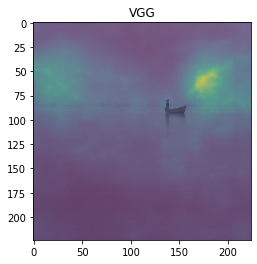

class: 460 class name: breakwater, groin, groyne, mole, bulwark, seawall, jetty


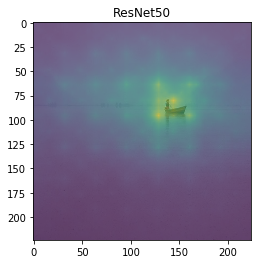

class: 913 class name: wreck


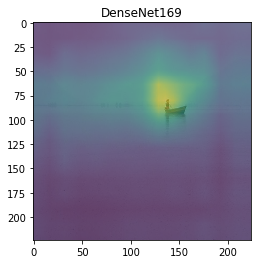

class: 472 class name: canoe


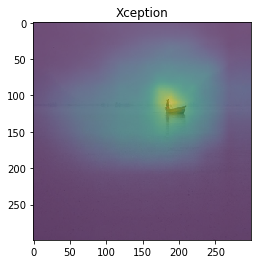

In [8]:
for base_model,preprocess,name in zip(base_models,base_preprocess,base_model_names):
  '''
  image loading and preprocessing
  '''
  img = load_img(img_path, target_size=(base_model.layers[0].input_shape[0][1],base_model.layers[0].input_shape[0][2]))
  img= img_to_array(img)
  input_= np.expand_dims(img, axis=0)
  input_=preprocess(input_)
  '''
  since the fullgrad model deals with representation of relu layers, 
  last layer softmax is removed and it's input features are mul with 
  weights and added with bias of last layer.

  This process can be ignored as it is done to manually check 
  base model output and fullgrad sum.

  '''
  #newmodel=Model(base_model.input,base_model.layers[-2].output)
  #feat=newmodel.predict(input_)
  #base_weights=base_model.get_weights()
  #out_=feat.dot(base_weights[-2])+base_weights[-1]

  '''
  create fullgrad model and fullgrad saliency for the
  given input . fullgrad completeness check can be done
  or ignored here if prevously done once.

  Note: default num classes is 1000 , for custom model use
  FullGrad(base_model,num_classes)
  '''
  fullgrad=FullGrad(base_model,class_names=imagenet_classes_dict)
  #fullgrad.checkCompleteness(input_)
  cam=fullgrad.saliency(input_)
  cam=fullgrad.postprocess_saliency_map(cam[0])
  plt.title(name)
  plt.imshow(cv2.resize(plt.imread(img_path),(base_model.layers[0].input_shape[0][1],base_model.layers[0].input_shape[0][2])))
  plt.imshow(cam,alpha=0.5)
  plt.show()  